In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.set_cmap("RdBu_r")

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import KFold, ParameterGrid, BaseCrossValidator, train_test_split
from sklearn.base import clone

In [ ]:
def linear_kernel(X_A, X_B=None):
    """
    Calculate linear kernel matrix between two sets of feature-vectors, so that:

        k_ij = <x_i, x_j>

    :param X_A: array-like, shape=(n_samples_A, d), feature-matrix of set A
    :param X_B: array-like, shape=(n_samples_B, d), feature-matrix of set B or None, than Y = X

    :return: array-like, shape=(n_samples_A, n_samples_B), kernel matrix
    """
    if X_B is None:
        X_B = X_A

    # YOUR CODE HERE
    K_AB = np.dot(X_A, X_B.T)
    
    return K_AB

In [ ]:
X_A = np.array([[1], [2], [3], [4]])
X_B = np.array([[0], [2], [1]])

# Test size
np.testing.assert_equal(linear_kernel(X_A, X_B).shape, (4, 3))
np.testing.assert_equal(linear_kernel(X_A).shape, (4, 4))

# Test values
np.testing.assert_equal(linear_kernel(X_A)[0, 0], 1)
np.testing.assert_equal(linear_kernel(X_A)[1, 1], 4)
np.testing.assert_equal(linear_kernel(X_A)[0, 2], 3)
np.testing.assert_equal(linear_kernel(X_A)[2, 0], 3)

np.testing.assert_equal(linear_kernel(X_A, X_B)[0, 0], 0)
np.testing.assert_equal(linear_kernel(X_A, X_B)[0, 1], 2)


In [ ]:
def gaussian_kernel(X_A, X_B=None, sigma=None):
    """
    Calculate the Gaussian kernel matrix, so that

        k_ij = exp(-||x_i - x_j||^2 / 2 * sigma^2)

    :param X_A: array-like, shape=(n_samples_A, n_features), feature-matrix of set A
    :param X_B: array-like, shape=(n_samples_B, n_features), feature-matrix of set B or None, than X_B = X_A
    :param sigma: scalar, bandwidth parameter

    :return: array-like, shape=(n_samples_A, n_samples_B), kernel matrix
    """
    if X_B is None:
        X_B = X_A

    n_A = X_A.shape[0]
    n_B = X_B.shape[0]

    if sigma is None:
        sigma = np.sqrt(X_A.shape[1] / 2.0)

    # YOUR CODE HERE
    K_AB = np.empty([n_A, n_B])
    for i in range(n_A):
        for j in range(n_B):
            K_AB[i, j] = np.exp(-np.sum((X_A[i, :] - X_B[j, :])**2) / 2*sigma**2)

    return K_AB

In [ ]:
X_A = np.array([[1], [2], [3], [4]])
X_B = np.array([[0], [2], [1]])

# Test size
np.testing.assert_equal(gaussian_kernel(X_A, X_B).shape, (4, 3))
np.testing.assert_equal(gaussian_kernel(X_A).shape, (4, 4))

# Test values
np.testing.assert_equal(gaussian_kernel(X_A, sigma=1)[0, 0], 1)
np.testing.assert_equal(gaussian_kernel(X_A, sigma=1)[1, 1], 1)
np.testing.assert_equal(gaussian_kernel(X_A, sigma=1)[0, 2], np.exp(-2))
np.testing.assert_equal(gaussian_kernel(X_A, sigma=1)[2, 0], np.exp(-2))

np.testing.assert_equal(gaussian_kernel(X_A, X_B, sigma=1)[0, 0], np.exp(-0.5))
np.testing.assert_equal(gaussian_kernel(X_A, X_B, sigma=1)[0, 1], np.exp(-0.5))


In [14]:
class ParzenWindowClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel="gaussian", sigma=None):
        """
        Parzen Window Classifier

        :param kernel: string, specifying which kernel to use. Can be 'gaussian' or 'linear'.
        :param sigma: scalar, gaussian kernel parameter, can be None if the linear kernel is used.
        """
        # Parzen Window Classifier model parameter
        self.b = None  # bias term
        self.alphas = None  # dual variables
        
        # Training data needed for the prediction phase
        self.X_train = None

        # Set up kernel function
        self.kernel = kernel
        self.sigma = sigma

    def fit(self, X_train, y_train):
        """
        Fit a Parzen Window Classifier using training data

        :param X_train: array-like, shape=(n_samples, n_features), feature-matrix
        :param y_train: array-like, shape=(n_samples,) or (n_samples, 1), label vector
        """
        # Calculate the specified kernel
        self.X_train = X_train
        KX_train = self._get_kernel(self.X_train)

        # Get indices of positive and negative examples: I_n, I_p
        # YOUR CODE HERE
        I_n = np.where(y_train==-1)[0]
        I_p = np.where(y_train==1)[0]

        # Count the number of postitive and negative examples: n_n, n_p
        # YOUR CODE HERE
        n_n = len(I_n)
        n_p = len(I_p)
        
        # Calcualte the bias term: self.b
        # YOUR CODE HERE
        subset_n = X_train[I_n]
        subset_p = X_train[I_p]
        self.b = 0.5*np.sum(self._get_kernel(subset_n, self.X_train)) / (n_n**2) - 0.5*np.sum(self._get_kernel(subset_p, self.X_train)) / (n_p**2)
        # Calculate alpha_i's: self.alpha
        self.alphas = np.zeros((n_n + n_p, 1))
        # YOUR CODE HERE
        self.alphas[np.where(y_train==1)[0]] = 1/n_p
        self.alphas[np.where(y_train==-1)[0]] = -1/n_n
        
    def decision_function(self, X):
        """
        Calculate decision function:
            g(x) = sum_i a_i k(x_i, x) + b

        :param X: array-like, shape=(n_samples_test, n_features), feature-matrix of new data.
        :return: array-like, shape=(n_samples_test,), decision function value g(x) for all new data points
        """
        if self.alphas is None or self.b is None or self.X_train is None:
            raise RuntimeError("Call fit-function first.")

        # Calculate the specified kernel between the training and test examples
        KX_test_train = self._get_kernel(X, self.X_train)
        KX_test = self._get_kernel(X, X)

        # Calculate the value of the decision function for each test example
        # YOUR CODE HERE
        g_X = np.sum(np.dot(KX_test_train, self.alphas), axis = 1) + self.b
        return g_X.flatten()  # output a one-dimensional vector       
        
    def predict(self, X):
        """
        Predict labels using Parzen Window Classifier:
            h(x) = sign(g(x)), with g(x) being the decision function

        :param X: array-like, shape=(n_samples_test, n_features), feature-matrix of new data.
        :return: array-like, shape=(n_samples_test,), predicted labels {-1, 1} for all new data points
        """
        if self.alphas is None or self.b is None or self.X_train is None:
            raise RuntimeError("Call fit-function first.")
        
        # Calculate prediction h(x) = sign(g(x))
        # YOUR CODE HERE
        g_X = self.decision_function(X)
        h_X = np.zeros(g_X.shape)
        h_X[np.where(g_X>0)[0]] = 1
        h_X[np.where(g_X<=0)[0]] = -1
        
        return h_X

    def _get_kernel(self, X, Y=None):
        """
        Calcualte kernel matrix using specified kernel-function and parameters.

        :param X: array-like, shape=(n_samples_A, n_features), feature-matrix of set A
        :param Y: array-like, shape=(n_samples_B, n_features), feature-matrix of set B or None, than Y = X
        :return: array-like, shape=(n_samples_A, n_samples_B), kernel matrix
        """
        if self.kernel == "gaussian":
            return gaussian_kernel(X, Y, self.sigma)
        elif self.kernel == "linear":
            return linear_kernel(X, Y)
        else:
            raise ValueError("Invalid kernel chosen.")


In [15]:
X, y = make_blobs(n_samples=50, centers=[[1, 1], [1.5, 1.5]], cluster_std=[0.1, 0.1], 
                  random_state=80)
y[y==0] = -1

test_est = ParzenWindowClassifier(kernel="linear")
test_est.fit(X, y)

# Test correct shape of self.b and self.alphas
assert(np.isscalar(test_est.b))
np.testing.assert_equal(test_est.alphas.shape, (50, 1))

# Test correct shape of the predictions
X_test = np.array([[1, 1], [1.5, 1.5], [1, 0], [2, 3]])

# Validate predictions
np.testing.assert_equal(test_est.decision_function(X_test).shape, (4,))

np.testing.assert_equal(test_est.predict(X_test).shape, (4,))
np.testing.assert_equal(test_est.predict(X_test), np.array([-1, 1, -1, 1]))

# Validate score
np.testing.assert_equal(test_est.score(X, y), 1.0)


In [16]:
# Create synthetic data (Please do not change the random_state!)
X_blobs, y_blobs = make_blobs(n_samples=500, centers=[[1, 1], [3, 3]], cluster_std=[0.5, 1.15], 
                              random_state=80)
X_moons, y_moons = make_moons(n_samples=500, noise=0.25, random_state=797)

# Make labels being {-1, 1}
y_blobs[y_blobs==0] = -1
y_moons[y_moons==0] = -1

# Split data
X_blobs_train, X_blobs_test, y_blobs_train, y_blobs_test = train_test_split(
    X_blobs, y_blobs, random_state=319)
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, random_state=747)

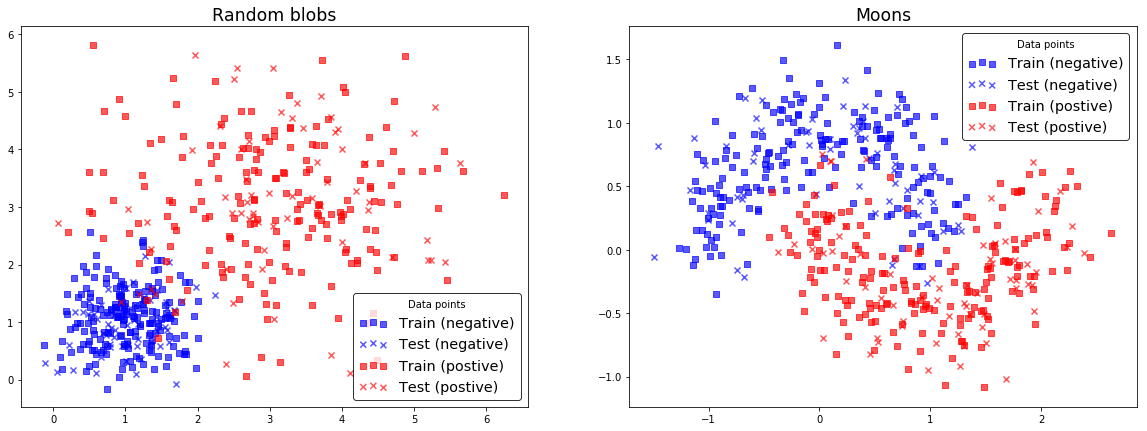

In [17]:
# Plot datasets
fig, axrr = plt.subplots(1, 2, figsize=(20, 7))

# Blobs
for l_str, l_num, col in [("negative", -1, "blue"), ("postive", 1, "red")]:    
    axrr[0].scatter(
        X_blobs_train[y_blobs_train==l_num, 0], X_blobs_train[y_blobs_train==l_num, 1],
        c=col, alpha=0.65, label="Train (%s)" % l_str, marker="s")
    
    axrr[0].scatter(
        X_blobs_test[y_blobs_test==l_num, 0], X_blobs_test[y_blobs_test==l_num, 1],
        c=col, alpha=0.65, label="Test (%s)" % l_str, marker="x")
        
# Blobs
for l_str, l_num, col in [("negative", -1, "blue"), ("postive", 1, "red")]:    
    axrr[1].scatter(
        X_moons_train[y_moons_train==l_num, 0], X_moons_train[y_moons_train==l_num, 1],
        c=col, alpha=0.65, label="Train (%s)" % l_str, marker="s")
    
    axrr[1].scatter(
        X_moons_test[y_moons_test==l_num, 0], X_moons_test[y_moons_test==l_num, 1],
        c=col, alpha=0.65, label="Test (%s)" % l_str, marker="x")


axrr[0].set_title("Random blobs", fontsize="xx-large")
axrr[0].legend(title="Data points", fontsize="x-large", scatterpoints=3, edgecolor="k")

axrr[1].set_title("Moons", fontsize="xx-large")
axrr[1].legend(title="Data points", fontsize="x-large", scatterpoints=3, edgecolor="k")

plt.show()